### bidsify abcd files and match ahrb for simulations

In [1]:
import os
import pandas as pd
from pathlib import Path

basedir = Path('/Users/poldrack/data_unsynced/ABCD/ABCC_mid_year2followupyarm1_recoded')
bidsdir = Path('/Users/poldrack/Dropbox/code/simulations/MID_simulation/ABCD')

if not bidsdir.exists():
    bidsdir.mkdir()

In [2]:
subdirs = list(basedir.glob('sub*'))
print(f'found {len(subdirs)} subject dirs')

def get_subcode_from_path(path):
    return path.name.split('_')[0].replace('sub-','')

subject_codes = list(set([get_subcode_from_path(i) for i in subdirs]))

ctr = 1
subcode_dict = {}
for subcode in subject_codes:
    if subcode not in subcode_dict:
        subcode_dict[subcode] = ctr
        ctr += 1

print(f'found {len(subcode_dict)} unique subject codes')


found 8749 subject dirs
found 4383 unique subject codes


In [3]:
    , , , , 

In [34]:
def recode_abcd_df(df):
    rename_dict = {}
    trial_recode_dict = {
        'SmallPun': 'SmallLoss', 
        'LgPun': 'LargeLoss', 
        'Triangle': 'NoMoneyStake', 
        'LgReward': 'LargeGain', 
        'SmallReward': 'SmallGain'}
    df['Condition'] = df['Condition'].replace(trial_recode_dict)
    for col in df.columns:
        if 'OnsetTime' in col:
            rename_dict[col] = col.replace('.OnsetTime', '_ONSET').upper().replace('ANTICIPATION', 'FIXATION')
        if 'Duration' in col:
            rename_dict[col] = col.replace('.Duration', '_DURATION').upper().replace('ANTICIPATION', 'FIXATION')
        rename_dict['SubTrial'] = 'trial_number'
        rename_dict['Condition'] = 'TRIAL_TYPE'
        rename_dict['prbacc'] = 'PROBE_HIT'
        rename_dict['prbrt'] = 'PROBE_MRT'
    df = df.rename(columns=rename_dict)
    del df['Subject']
    del df['SessionDate']
    return df
    



In [35]:
# make bids dirs

missing_files = []
AHRB_columns = ['TRIAL_TYPE', 'CUE_ONSET', 'CUE_DURATION', 'FIXATION_ONSET',
       'FIXATION_DURATION', 'PROBE_ONSET', 'PROBE_DURATION', 'FEEDBACK_ONSET',
       'FEEDBACK_DURATION', 'PROBE_HIT',
       'PROBE_MRT']

for subcode in subject_codes:
    sub_id = f'sub-{subcode_dict[subcode]:02d}'
    subdir = bidsdir / sub_id / 'ses-1/func'
    if not subdir.exists():
        subdir.mkdir(parents=True)
    for run in range(1,3):
        origfile = basedir / f'sub-{subcode}_ses-2YearFollowUpYArm1_task-MID_run-{run:02d}_events.csv'
        if not origfile.exists():
            missing_files.append(origfile)
            continue
        df = pd.read_csv(origfile)
        df = recode_abcd_df(df)
        assert all([i in df.columns for i in AHRB_columns])
        bidsfile = subdir / f'{sub_id}_ses-1_task-mid_run-{run:02d}_events.tsv'
        df.to_csv(bidsfile, sep='\t', index=False)

print(f'found {len(missing_files)} missing files')
    


found 17 missing files


In [38]:
# test

from simulation_funcs import get_subdata_long, create_design_matrices

subdata = get_subdata_long(1, 'ABCD')

design_matrices = create_design_matrices(subdata)


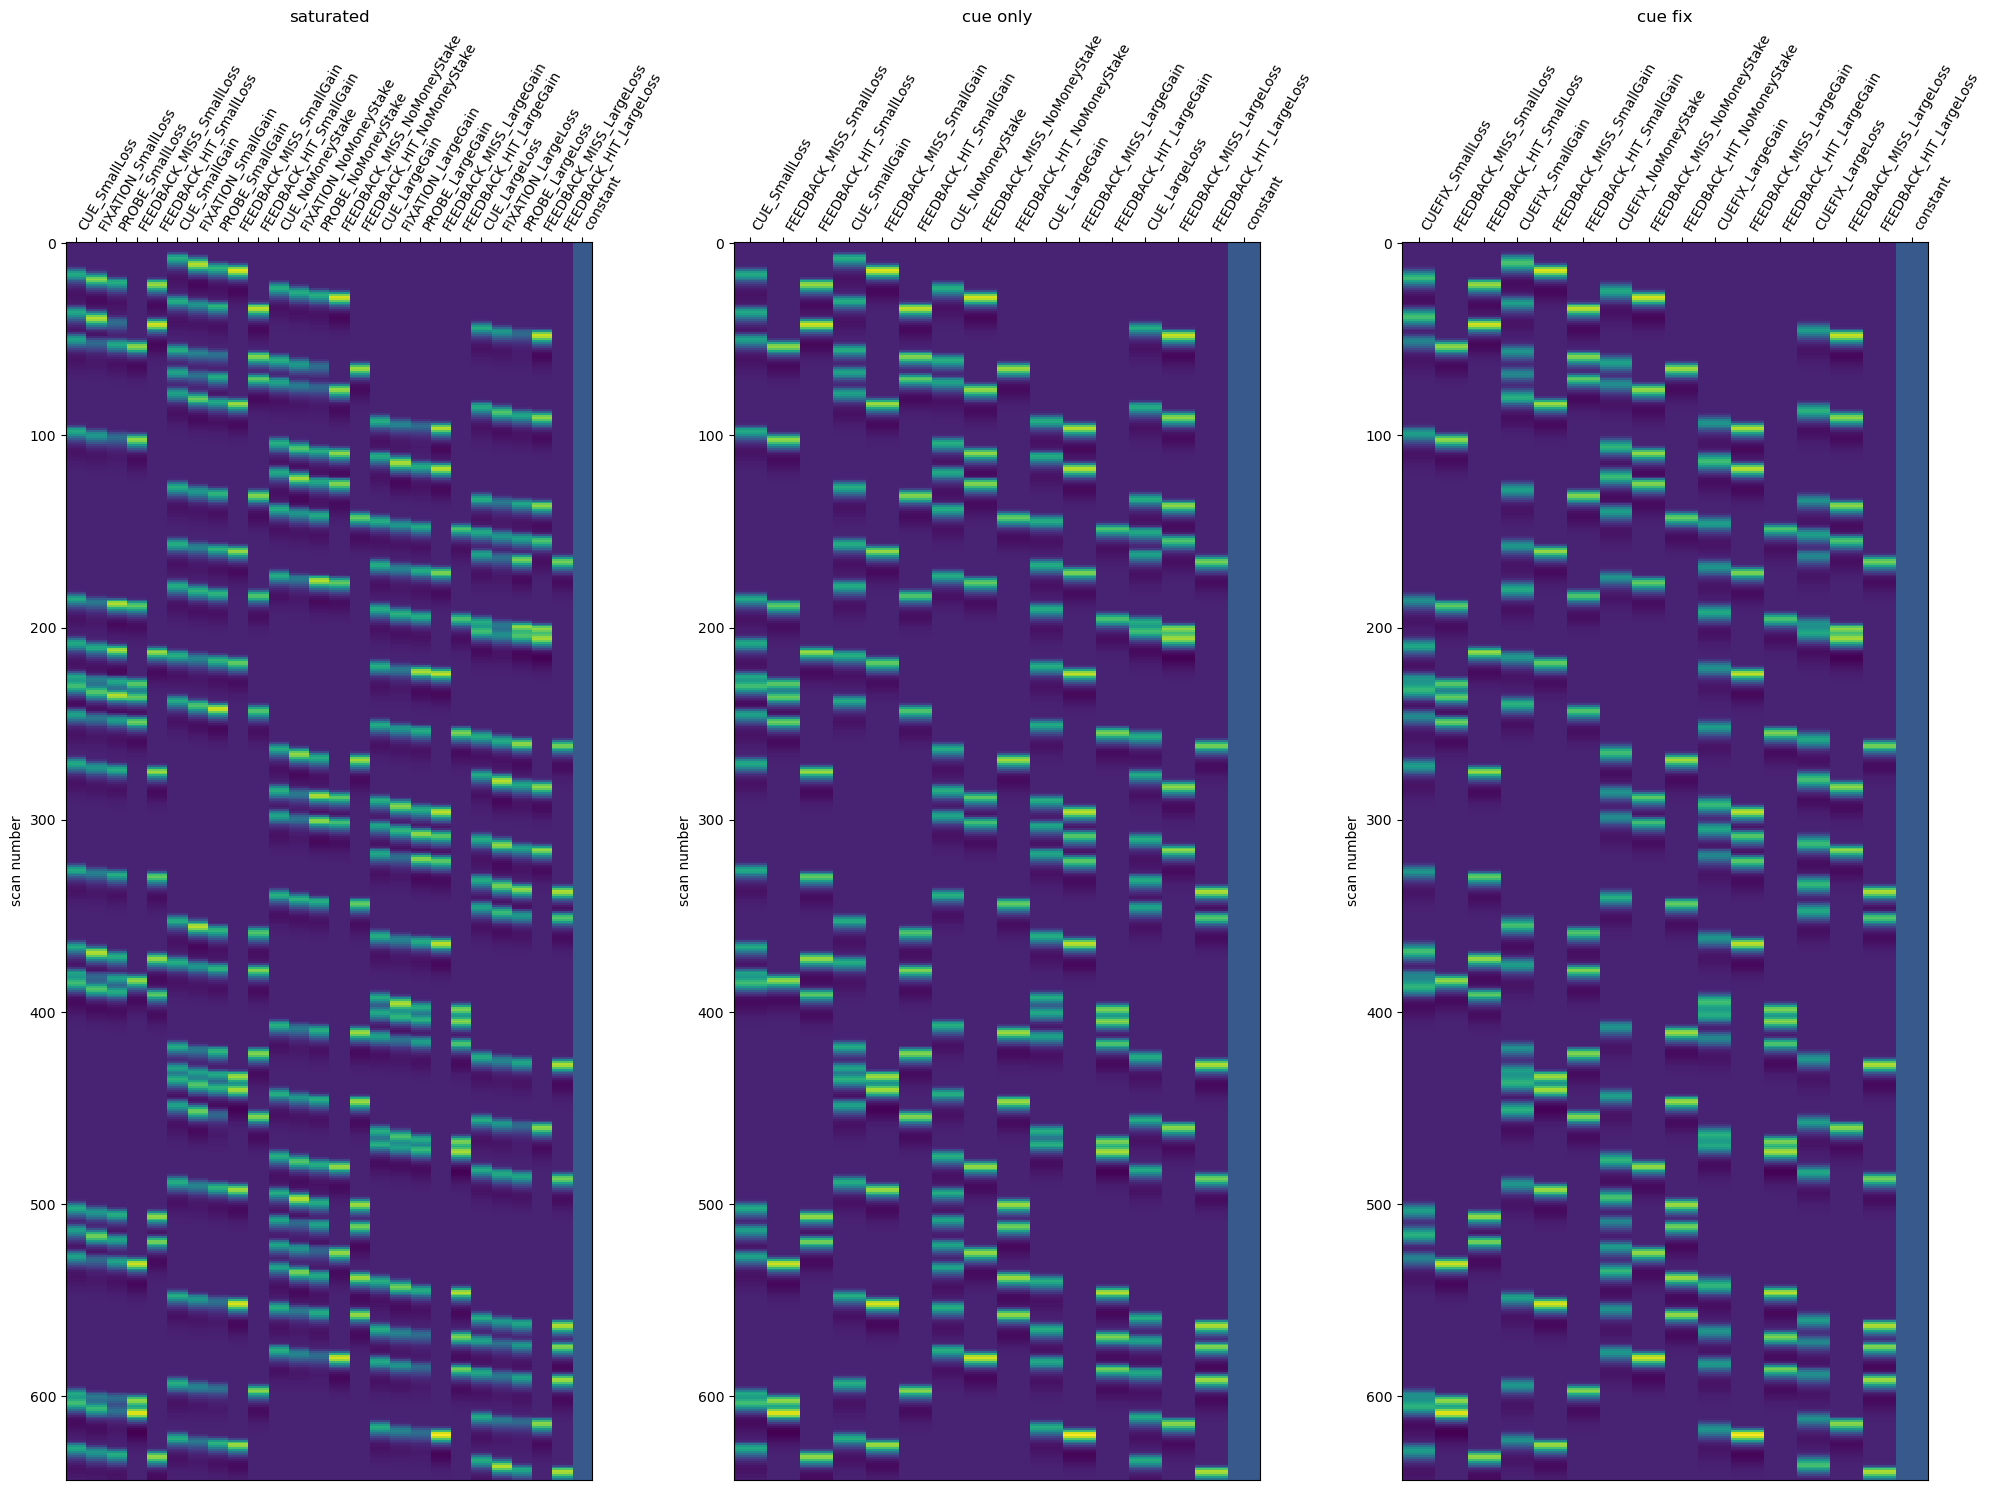

In [42]:
import matplotlib.pyplot as plt
from simulation_plotting import plot_design_ordered_regressors

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax_flat = ax.flatten()
for i, desname in enumerate(design_matrices.keys()):
    plot_design_ordered_regressors(design_matrices[desname], desname, ax=ax_flat[i])
plt.show()
